NEURAL NETWORK WITH 5-FOLD CROSS-VALIDATION

Loading data...
Data loaded - Train: (127656, 5000), Test: (31915, 5000)
STARTING 5-FOLD CROSS-VALIDATION
FOLD 1/5
Train: (102124, 5000), Validation: (25532, 5000)

Training fold 1...

Fold 1 Results:
  Training Time: 0.44 min
  Best Epoch: 2
  Validation Accuracy: 0.9140
  Validation Macro F1: 0.4616
  Validation Weighted F1: 0.6785
  Validation ROC AUC (macro): 0.9673
FOLD 2/5
Train: (102125, 5000), Validation: (25531, 5000)

Training fold 2...

Fold 2 Results:
  Training Time: 0.46 min
  Best Epoch: 3
  Validation Accuracy: 0.9170
  Validation Macro F1: 0.5098
  Validation Weighted F1: 0.6774
  Validation ROC AUC (macro): 0.9699
FOLD 3/5
Train: (102125, 5000), Validation: (25531, 5000)

Training fold 3...

Fold 3 Results:
  Training Time: 0.48 min
  Best Epoch: 3
  Validation Accuracy: 0.9157
  Validation Macro F1: 0.5052
  Validation Weighted F1: 0.6744
  Validation ROC AUC (macro): 0.9707
FOLD 4/5
Train: (102125, 5000), Validation: (255

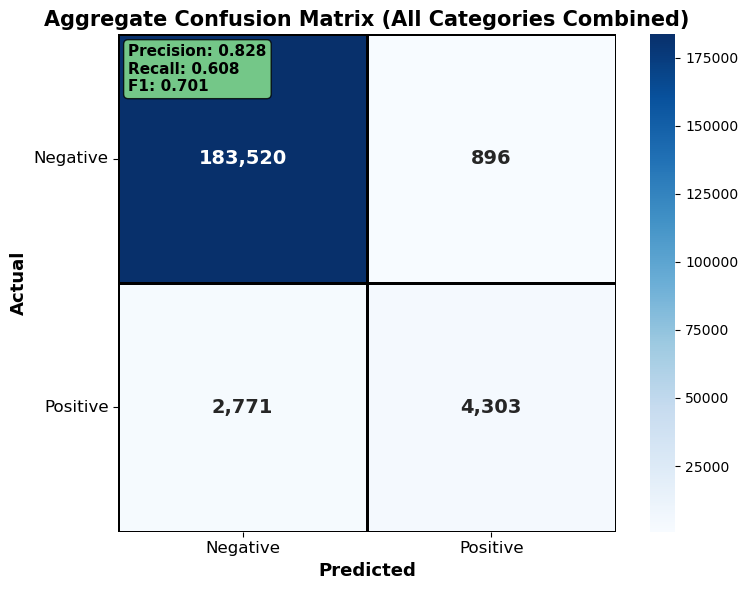

OVERALL CLASSIFICATION REPORT (All Categories Combined)

Note: This treats the multi-label problem as binary for each sample.
Metrics are calculated across all 6 categories combined.

              precision    recall  f1-score   support

    Negative     0.9851    0.9951    0.9901    184416
    Positive     0.8277    0.6083    0.7012      7074

    accuracy                         0.9809    191490
   macro avg     0.9064    0.8017    0.8457    191490
weighted avg     0.9793    0.9809    0.9794    191490

GENERATING VISUALIZATIONS


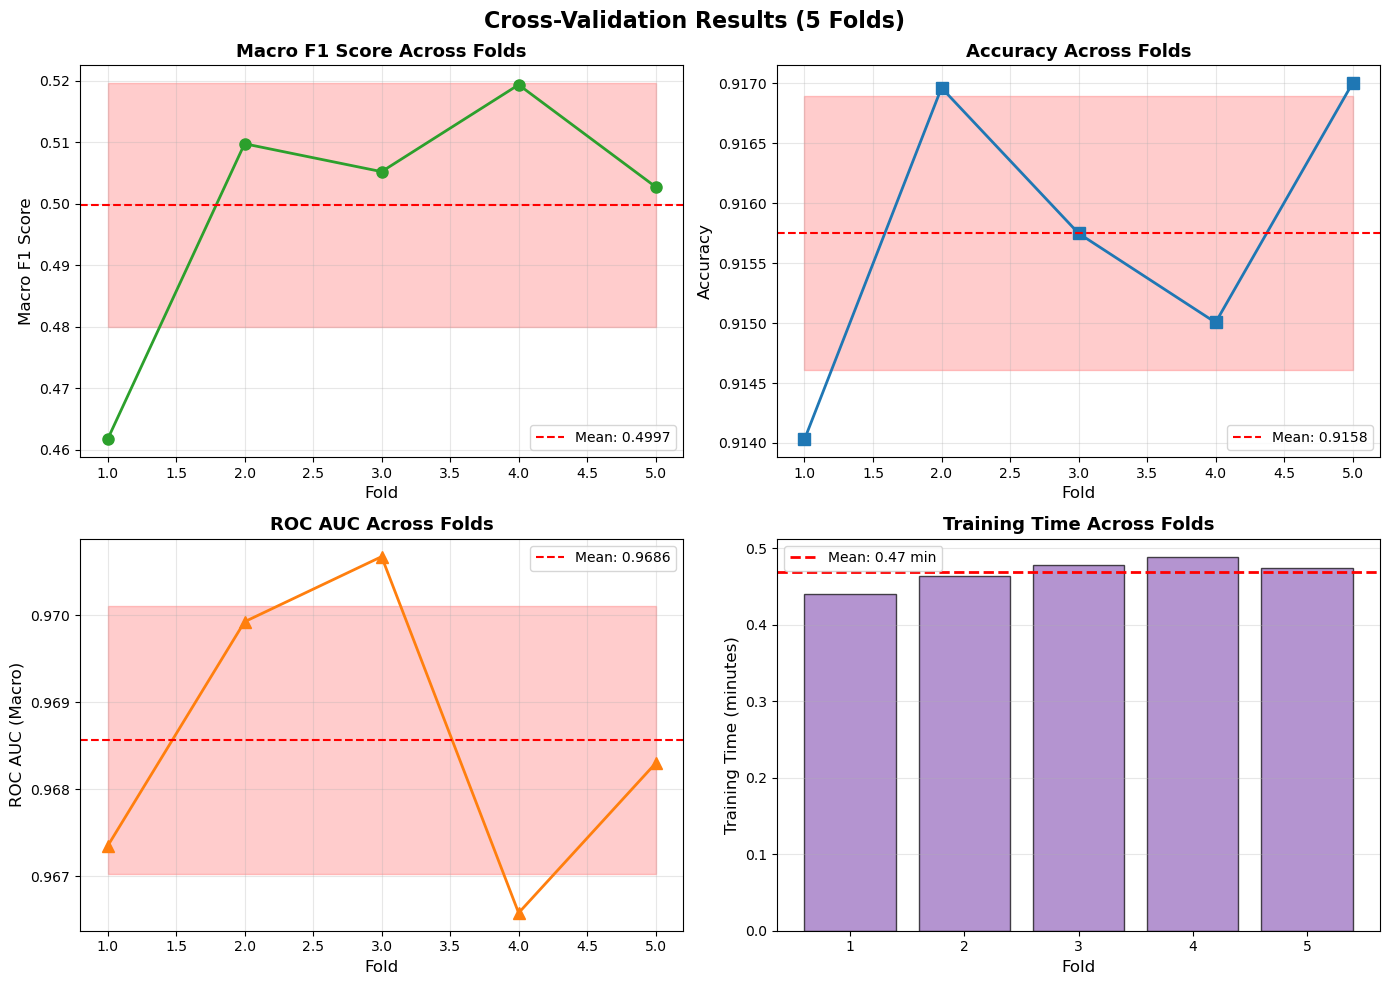

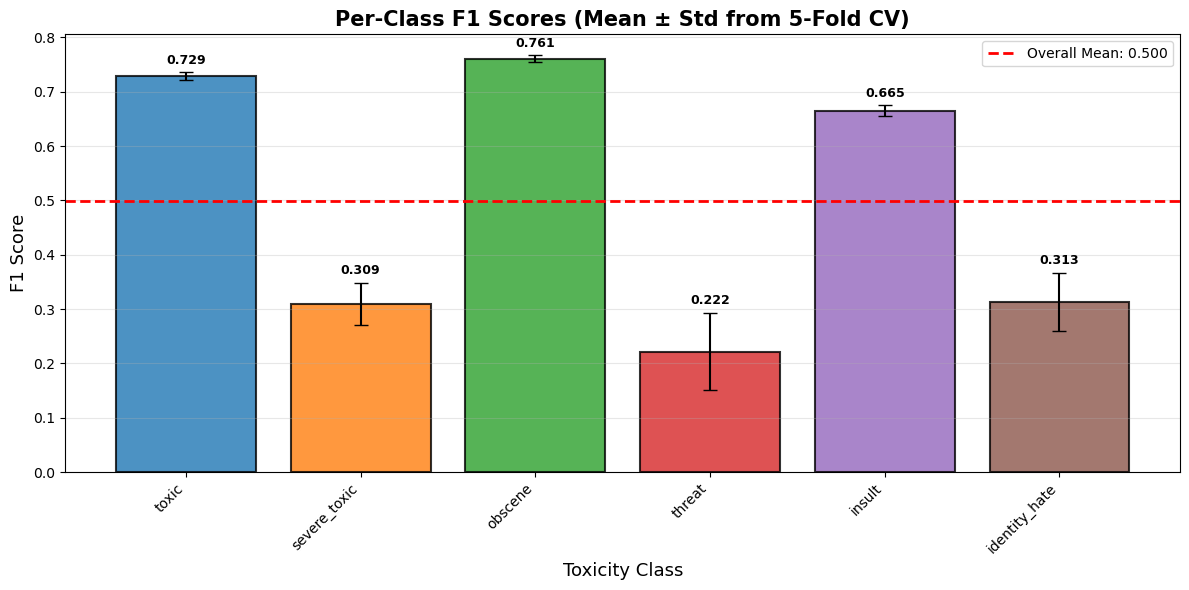

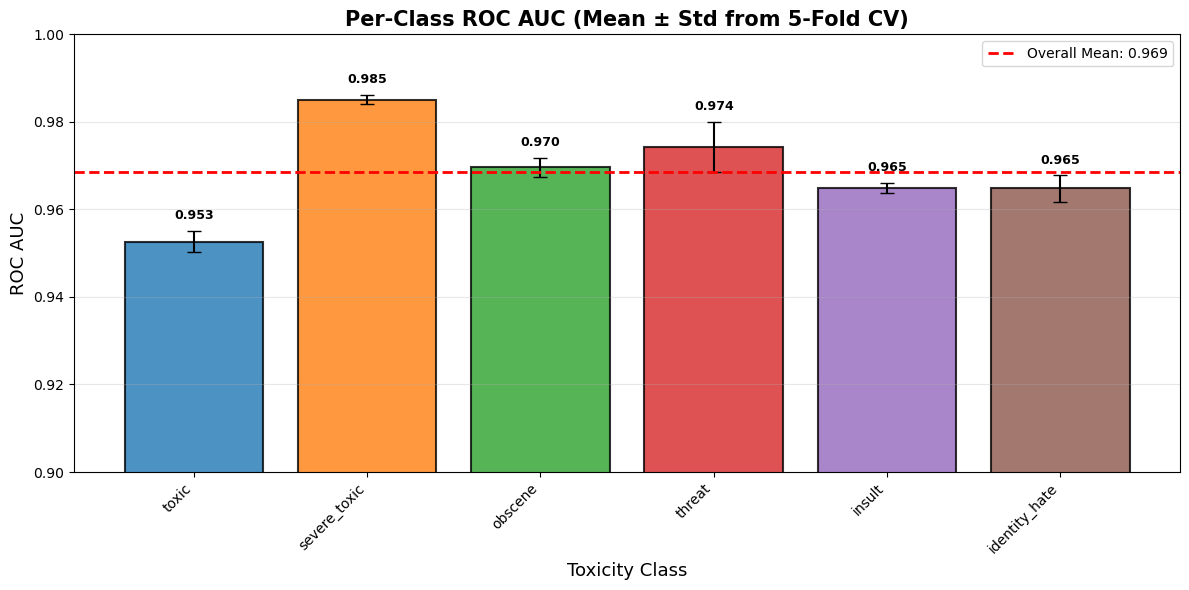

In [11]:
import tensorflow as tf
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import time
import pandas as pd
import seaborn as sns
import os

num_cores = os.cpu_count()
os.environ['TF_NUM_INTEROP_THREADS'] = str(num_cores)
os.environ['TF_NUM_INTRAOP_THREADS'] = str(num_cores)
os.environ['OMP_NUM_THREADS'] = str(num_cores)

np.random.seed(42)
tf.random.set_seed(42)
print("NEURAL NETWORK WITH 5-FOLD CROSS-VALIDATION")
print("="*70)

print("\nLoading data...")
with open('../DATA/tfidf_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'].toarray()
X_test = data['X_test'].toarray()
y_train = np.array(data['y_train'])
y_test = np.array(data['y_test'])

print(f"Data loaded - Train: {X_train.shape}, Test: {X_test.shape}")

def build_nn(input_dim, num_labels, hidden_neurons=64):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_neurons, activation='relu', name='hidden_layer'),
        layers.Dense(num_labels, activation='sigmoid', name='output_layer')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = {
    'fold_num': [],
    'train_time': [],
    'val_accuracy': [],
    'val_macro_f1': [],
    'val_weighted_f1': [],
    'val_roc_auc_macro': [],
    'best_epoch': [],
    'class_f1': {label: [] for label in labels},
    'class_roc_auc': {label: [] for label in labels}
}
print(f"STARTING {n_folds}-FOLD CROSS-VALIDATION")
print("="*70)

fold_num = 1

for train_idx, val_idx in kfold.split(X_train):
    print(f"FOLD {fold_num}/{n_folds}")
    print(f"{'='*70}")

    X_train_fold = X_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_train_fold = y_train[train_idx]
    y_val_fold = y_train[val_idx]
    
    print(f"Train: {X_train_fold.shape}, Validation: {X_val_fold.shape}")

    model = build_nn(X_train_fold.shape[1], y_train_fold.shape[1], hidden_neurons=64)

    print(f"\nTraining fold {fold_num}...")
    start_time = time.time()
    
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
    
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    
    training_time = (time.time() - start_time) / 60
    best_epoch = len(history.history['loss']) - 5

    y_val_pred_prob = model.predict(X_val_fold, verbose=0)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    val_accuracy = accuracy_score(y_val_fold, y_val_pred)
    val_macro_f1 = f1_score(y_val_fold, y_val_pred, average='macro')
    val_weighted_f1 = f1_score(y_val_fold, y_val_pred, average='weighted')

    class_roc_aucs = []
    for i in range(len(labels)):
        try:
            roc_auc = roc_auc_score(y_val_fold[:, i], y_val_pred_prob[:, i])
            class_roc_aucs.append(roc_auc)
            cv_results['class_roc_auc'][labels[i]].append(roc_auc)
        except:
            class_roc_aucs.append(0.0)
            cv_results['class_roc_auc'][labels[i]].append(0.0)
    
    val_roc_auc_macro = np.mean(class_roc_aucs)

    class_f1s = []
    for i, label in enumerate(labels):
        f1 = f1_score(y_val_fold[:, i], y_val_pred[:, i])
        cv_results['class_f1'][label].append(f1)
        class_f1s.append(f1)

    cv_results['fold_num'].append(fold_num)
    cv_results['train_time'].append(training_time)
    cv_results['val_accuracy'].append(val_accuracy)
    cv_results['val_macro_f1'].append(val_macro_f1)
    cv_results['val_weighted_f1'].append(val_weighted_f1)
    cv_results['val_roc_auc_macro'].append(val_roc_auc_macro)
    cv_results['best_epoch'].append(best_epoch)

    print(f"\nFold {fold_num} Results:")
    print(f"  Training Time: {training_time:.2f} min")
    print(f"  Best Epoch: {best_epoch}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Validation Macro F1: {val_macro_f1:.4f}")
    print(f"  Validation Weighted F1: {val_weighted_f1:.4f}")
    print(f"  Validation ROC AUC (macro): {val_roc_auc_macro:.4f}")
    
    fold_num += 1

    del model
    tf.keras.backend.clear_session()

print("CROSS-VALIDATION SUMMARY")
print("="*70)

print(f"\nOverall Metrics (Mean ± Std across {n_folds} folds):")
print(f"{'Metric':<30} {'Mean':<15} {'Std':<15}")
print("-"*70)
print(f"{'Validation Accuracy':<30} {np.mean(cv_results['val_accuracy']):.4f} ± {np.std(cv_results['val_accuracy']):.4f}")
print(f"{'Validation Macro F1':<30} {np.mean(cv_results['val_macro_f1']):.4f} ± {np.std(cv_results['val_macro_f1']):.4f}")
print(f"{'Validation Weighted F1':<30} {np.mean(cv_results['val_weighted_f1']):.4f} ± {np.std(cv_results['val_weighted_f1']):.4f}")
print(f"{'Validation ROC AUC (macro)':<30} {np.mean(cv_results['val_roc_auc_macro']):.4f} ± {np.std(cv_results['val_roc_auc_macro']):.4f}")
print(f"{'Training Time (minutes)':<30} {np.mean(cv_results['train_time']):.2f} ± {np.std(cv_results['train_time']):.2f}")
print(f"{'Best Epoch':<30} {np.mean(cv_results['best_epoch']):.1f} ± {np.std(cv_results['best_epoch']):.1f}")
print("-"*70)

print(f"\nPer-Class F1 Scores (Mean ± Std):")
print(f"{'Class':<20} {'Mean F1':<15} {'Std':<15}")
print("-"*70)
for label in labels:
    mean_f1 = np.mean(cv_results['class_f1'][label])
    std_f1 = np.std(cv_results['class_f1'][label])
    print(f"{label:<20} {mean_f1:.4f} ± {std_f1:.4f}")
print("-"*70)

print(f"\nPer-Class ROC AUC (Mean ± Std):")
print(f"{'Class':<20} {'Mean ROC AUC':<15} {'Std':<15}")
print("-"*70)
for label in labels:
    mean_auc = np.mean(cv_results['class_roc_auc'][label])
    std_auc = np.std(cv_results['class_roc_auc'][label])
    print(f"{label:<20} {mean_auc:.4f} ± {std_auc:.4f}")
print("TRAINING FINAL MODEL ON FULL TRAINING SET")
print("="*70)
from sklearn.model_selection import train_test_split
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"\nTrain: {X_train_final.shape}, Validation: {X_val_final.shape}")

final_model = build_nn(X_train_final.shape[1], y_train_final.shape[1], hidden_neurons=64)

print("\nTraining final model...")
start_time = time.time()

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

final_training_time = (time.time() - start_time) / 60
print("FINAL MODEL TEST SET EVALUATION")
print("="*70)

y_test_pred_prob = final_model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_macro_f1 = f1_score(y_test, y_test_pred, average='macro')
test_weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\nTest Set Results:")
print(f"{'Test Accuracy':<30} {test_accuracy:.4f}")
print(f"{'Test Macro F1':<30} {test_macro_f1:.4f}")
print(f"{'Test Weighted F1':<30} {test_weighted_f1:.4f}")
print(f"{'Training Time':<30} {final_training_time:.2f} min")
print("-"*70)

print(f"\nPer-Class Test Results:")
print(f"{'Class':<20} {'F1 Score':<15} {'ROC AUC':<15}")
print("-"*70)
for i, label in enumerate(labels):
    f1 = f1_score(y_test[:, i], y_test_pred[:, i])
    roc_auc = roc_auc_score(y_test[:, i], y_test_pred_prob[:, i])
    print(f"{label:<20} {f1:.4f}          {roc_auc:.4f}")
print("GENERATING CONFUSION MATRICES")
print("="*70)
confusion_matrices = {}
for i, label in enumerate(labels):
    cm = confusion_matrix(y_test[:, i], y_test_pred[:, i])
    confusion_matrices[label] = cm
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{label.upper()}:")
    print(f"  True Negatives:  {tn:>6,}  |  False Positives: {fp:>6,}")
    print(f"  False Negatives: {fn:>6,}  |  True Positives:  {tp:>6,}")
    print(f"  Precision: {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}  |  Recall: {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f}")
print("AGGREGATE CONFUSION MATRIX")
print("="*70)
aggregate_cm = np.zeros((2, 2), dtype=int)
for label in labels:
    aggregate_cm += confusion_matrices[label]

print("\nTotal across all 6 toxicity categories:")
tn, fp, fn, tp = aggregate_cm.ravel()
print(f"  True Negatives:  {tn:>7,}")
print(f"  False Positives: {fp:>7,}")
print(f"  False Negatives: {fn:>7,}")
print(f"  True Positives:  {tp:>7,}")
print(f"\n  Overall Precision: {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}")
print(f"  Overall Recall:    {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f}")
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(aggregate_cm, annot=True, fmt=',d', cmap='Blues', ax=ax,
            cbar=True, square=True, linewidths=2, linecolor='black',
            annot_kws={'size': 14, 'weight': 'bold'})

ax.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax.set_ylabel('Actual', fontsize=13, fontweight='bold')
ax.set_title('Aggregate Confusion Matrix (All Categories Combined)', fontsize=15, fontweight='bold')
ax.set_xticklabels(['Negative', 'Positive'], rotation=0, fontsize=12)
ax.set_yticklabels(['Negative', 'Positive'], rotation=0, fontsize=12)
precision = tp/(tp+fp) if (tp+fp) > 0 else 0
recall = tp/(tp+fn) if (tp+fn) > 0 else 0
f1_agg = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

metrics_text = f'Precision: {precision:.3f}\nRecall: {recall:.3f}\nF1: {f1_agg:.3f}'
ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('confusion_matrix_aggregate.png', dpi=300, bbox_inches='tight')
plt.show()
print("OVERALL CLASSIFICATION REPORT (All Categories Combined)")
print("\nNote: This treats the multi-label problem as binary for each sample.")
print("Metrics are calculated across all 6 categories combined.\n")
overall_report = classification_report(
    y_test.ravel(),
    y_test_pred.ravel(),
    target_names=['Negative', 'Positive'],
    digits=4
)
print(overall_report)
with open('classification_report.txt', 'w') as f:
    f.write("CLASSIFICATION REPORT - TOXICITY DETECTION MODEL\n")
    f.write("="*70 + "\n\n")
    f.write("PER-CLASS REPORTS:\n")
    f.write("="*70 + "\n")
    for i, label in enumerate(labels):
        f.write(f"\n{label.upper().replace('_', ' ')}\n")
        f.write("-"*70 + "\n")
        report = classification_report(
            y_test[:, i], 
            y_test_pred[:, i],
            target_names=[f'Not {label}', label],
            digits=4
        )
        f.write(report + "\n")
    
    f.write("OVERALL CLASSIFICATION REPORT (All Categories Combined)\n")
    f.write(overall_report)
    f.write("\n" + "="*70 + "\n")
    f.write("SUMMARY STATISTICS\n")
    f.write("="*70 + "\n\n")
    f.write(f"Test Accuracy:        {test_accuracy:.4f}\n")
    f.write(f"Test Macro F1:        {test_macro_f1:.4f}\n")
    f.write(f"Test Weighted F1:     {test_weighted_f1:.4f}\n")
    f.write(f"\nCV Macro F1:          {np.mean(cv_results['val_macro_f1']):.4f} ± {np.std(cv_results['val_macro_f1']):.4f}\n")
    f.write(f"CV Weighted F1:       {np.mean(cv_results['val_weighted_f1']):.4f} ± {np.std(cv_results['val_weighted_f1']):.4f}\n")
    f.write(f"CV ROC AUC (macro):   {np.mean(cv_results['val_roc_auc_macro']):.4f} ± {np.std(cv_results['val_roc_auc_macro']):.4f}\n")
    f.write(f"\nAggregate Precision:  {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}\n")
    f.write(f"Aggregate Recall:     {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f}\n")
print("GENERATING VISUALIZATIONS")
print("="*70)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].plot(cv_results['fold_num'], cv_results['val_macro_f1'], 
                marker='o', linewidth=2, markersize=8, color='#2ca02c')
axes[0, 0].axhline(y=np.mean(cv_results['val_macro_f1']), color='red', 
                   linestyle='--', label=f"Mean: {np.mean(cv_results['val_macro_f1']):.4f}")
axes[0, 0].fill_between(cv_results['fold_num'],
                        np.mean(cv_results['val_macro_f1']) - np.std(cv_results['val_macro_f1']),
                        np.mean(cv_results['val_macro_f1']) + np.std(cv_results['val_macro_f1']),
                        alpha=0.2, color='red')
axes[0, 0].set_xlabel('Fold', fontsize=12)
axes[0, 0].set_ylabel('Macro F1 Score', fontsize=12)
axes[0, 0].set_title('Macro F1 Score Across Folds', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].plot(cv_results['fold_num'], cv_results['val_accuracy'], 
                marker='s', linewidth=2, markersize=8, color='#1f77b4')
axes[0, 1].axhline(y=np.mean(cv_results['val_accuracy']), color='red', 
                   linestyle='--', label=f"Mean: {np.mean(cv_results['val_accuracy']):.4f}")
axes[0, 1].fill_between(cv_results['fold_num'],
                        np.mean(cv_results['val_accuracy']) - np.std(cv_results['val_accuracy']),
                        np.mean(cv_results['val_accuracy']) + np.std(cv_results['val_accuracy']),
                        alpha=0.2, color='red')
axes[0, 1].set_xlabel('Fold', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy Across Folds', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].plot(cv_results['fold_num'], cv_results['val_roc_auc_macro'], 
                marker='^', linewidth=2, markersize=8, color='#ff7f0e')
axes[1, 0].axhline(y=np.mean(cv_results['val_roc_auc_macro']), color='red', 
                   linestyle='--', label=f"Mean: {np.mean(cv_results['val_roc_auc_macro']):.4f}")
axes[1, 0].fill_between(cv_results['fold_num'],
                        np.mean(cv_results['val_roc_auc_macro']) - np.std(cv_results['val_roc_auc_macro']),
                        np.mean(cv_results['val_roc_auc_macro']) + np.std(cv_results['val_roc_auc_macro']),
                        alpha=0.2, color='red')
axes[1, 0].set_xlabel('Fold', fontsize=12)
axes[1, 0].set_ylabel('ROC AUC (Macro)', fontsize=12)
axes[1, 0].set_title('ROC AUC Across Folds', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].bar(cv_results['fold_num'], cv_results['train_time'], 
               color='#9467bd', alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=np.mean(cv_results['train_time']), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: {np.mean(cv_results['train_time']):.2f} min")
axes[1, 1].set_xlabel('Fold', fontsize=12)
axes[1, 1].set_ylabel('Training Time (minutes)', fontsize=12)
axes[1, 1].set_title('Training Time Across Folds', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, axis='y', alpha=0.3)

plt.suptitle('Cross-Validation Results (5 Folds)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('cv_metrics_across_folds.png', dpi=300, bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(12, 6))

mean_f1s = [np.mean(cv_results['class_f1'][label]) for label in labels]
std_f1s = [np.std(cv_results['class_f1'][label]) for label in labels]

x_pos = np.arange(len(labels))
bars = ax.bar(x_pos, mean_f1s, yerr=std_f1s, capsize=5, 
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Toxicity Class', fontsize=13)
ax.set_ylabel('F1 Score', fontsize=13)
ax.set_title('Per-Class F1 Scores (Mean ± Std from 5-Fold CV)', fontsize=15, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.grid(True, axis='y', alpha=0.3)
ax.axhline(y=np.mean(mean_f1s), color='red', linestyle='--', linewidth=2,
           label=f'Overall Mean: {np.mean(mean_f1s):.3f}')
ax.legend()

for i, (bar, mean, std) in enumerate(zip(bars, mean_f1s, std_f1s)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
            f'{mean:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('cv_f1_scores_per_class.png', dpi=300, bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(12, 6))

mean_aucs = [np.mean(cv_results['class_roc_auc'][label]) for label in labels]
std_aucs = [np.std(cv_results['class_roc_auc'][label]) for label in labels]

bars = ax.bar(x_pos, mean_aucs, yerr=std_aucs, capsize=5,
              color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'],
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Toxicity Class', fontsize=13)
ax.set_ylabel('ROC AUC', fontsize=13)
ax.set_title('Per-Class ROC AUC (Mean ± Std from 5-Fold CV)', fontsize=15, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylim([0.9, 1.0])
ax.grid(True, axis='y', alpha=0.3)
ax.axhline(y=np.mean(mean_aucs), color='red', linestyle='--', linewidth=2,
           label=f'Overall Mean: {np.mean(mean_aucs):.3f}')
ax.legend()

for i, (bar, mean, std) in enumerate(zip(bars, mean_aucs, std_aucs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.002,
            f'{mean:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('cv_roc_auc_per_class.png', dpi=300, bbox_inches='tight')
plt.show()
final_model.save('toxicity_classifier_64neurons_cv.keras')

with open('cv_results.pkl', 'wb') as f:
    pickle.dump(cv_results, f)
summary_df = pd.DataFrame({
    'Fold': cv_results['fold_num'],
    'Accuracy': cv_results['val_accuracy'],
    'Macro_F1': cv_results['val_macro_f1'],
    'Weighted_F1': cv_results['val_weighted_f1'],
    'ROC_AUC_Macro': cv_results['val_roc_auc_macro'],
    'Training_Time_min': cv_results['train_time'],
    'Best_Epoch': cv_results['best_epoch']
})

summary_df.to_csv('cv_summary.csv', index=False)